In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
import torchvision
from torchvision import transforms as T
from torchvision import utils
import os
import xml.etree.ElementTree as ET
from PIL import Image
import cv2
import matplotlib.pyplot as plt
from torch.utils.data.dataloader import default_collate
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Parse XML files
def parse_xml(xml_file):
    tree = ET.parse(xml_file)
    root = tree.getroot()
    objects = []
    for obj in root.iter('object'):
        obj_dict = {
            'name': obj.find('name').text,
            'bbox': [
                int(obj.find('bndbox/xmin').text),
                int(obj.find('bndbox/ymin').text),
                int(obj.find('bndbox/xmax').text),
                int(obj.find('bndbox/ymax').text)
            ]
        }
        objects.append(obj_dict)
    return objects

# Visual bounding boxes
def visualize_image(image_path, objects):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # OpenCV uses BGR by default
    for obj in objects:
        bbox = obj['bbox']
        cv2.rectangle(image, (bbox[0], bbox[1]), (bbox[2], bbox[3]), (0, 255, 0), 2)
        cv2.putText(image, obj['name'], (bbox[0], bbox[1]-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)
    plt.imshow(image)
    plt.show()

In [3]:
your_label_map = {
    "Grasper": 1,
    "Bipolar": 2,
    "Hook": 3,
    "Scissors": 4,
    "Clipper": 5,
    "Irrigator": 6,
    "SpecimenBag": 7
}


def resize_bbox(bbox, in_size, out_size):
    """
    Adjust bounding box size.
    :param bbox: Original bounding box coordinates in the format [xmin, ymin, xmax, ymax]
    :param in_size: original image size (width, height)
    :param out_size: new image size (width, height)
    :return: adjusted bounding box coordinates
    """
    xmin, ymin, xmax, ymax = bbox
    scale_x = out_size[0] / in_size[0]
    scale_y = out_size[1] / in_size[1]
    xmin = int(xmin * scale_x)
    ymin = int(ymin * scale_y)
    xmax = int(xmax * scale_x)
    ymax = int(ymax * scale_y)
    return [xmin, ymin, xmax, ymax]


class CustomDataset(Dataset):
    def __init__(self, imgs_dir, anns_dir, transforms=None):
        self.imgs_dir = imgs_dir
        self.anns_dir = anns_dir
        self.transforms = transforms

        # Get the names of all image and annotation files, with extensions removed
        anns = set(os.path.splitext(file)[0] for file in os.listdir(anns_dir))
        imgs = anns

        # Keep image file names with matching annotations
        self.imgs = [file + '.jpg' for file in imgs]  # Assuming the image file is in .jpg format
        self.annotations = [file + '.xml' for file in anns]  # Assume that the annotation file is in .xml format

        # Make sure the image and annotation file lists are of equal length
        assert len(self.imgs) == len(self.annotations), "Images and annotations lists are not the same length"

    def __getitem__(self, idx):
        # print("getting")
        img_path = os.path.join(self.imgs_dir, self.imgs[idx])
        ann_path = os.path.join(self.anns_dir, self.annotations[idx])

        # read images
        image = Image.open(img_path).convert("RGB")
        original_size = image.size
        new_size = (600, 600)

        # Parse XML files using parse_xml function
        objects = parse_xml(ann_path)


        boxes = []
        labels = []
        for obj in objects:
            label_name = obj['name']
            label = your_label_map[label_name]  # Convert category name to integer
            labels.append(label)

            # Add bounding box coordinates
            bbox = obj['bbox']
            resized_bbox = resize_bbox(bbox, original_size, new_size)
            boxes.append(resized_bbox)

        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels

        if self.transforms is not None:
            image = self.transforms(image)  # Apply conversion to image
            # If necessary, you can also convert the target accordingly
            # For example, if random flipping is used, the bounding box of the target needs to be adjusted accordingly

        return image, target

    def __len__(self):
        return len(self.imgs)


In [7]:
from torchvision.transforms import functional as F


# imgs_dir = "/content/m2cai16-tool-locations/JPEGImages"
# anns_dir = "/content/m2cai16-tool-locations/Annotations"

imgs_dir = "drive/MyDrive/m2cai16-tool-locations/dummy root/dummy class"
anns_dir = "drive/MyDrive/m2cai16-tool-locations/Annotations"

def get_transform(train):
    transforms = []
    # Convert PIL image to PyTorch Tensor
    transforms.append(T.ToTensor())
    # if train:
    #     # Data augmentation during training phase, such as random horizontal flipping
    #     transforms.append(T.RandomHorizontalFlip(0.5))
    #     # More data enhancement operations can be added, such as:
    #     # transforms.append(T.RandomVerticalFlip(0.5))
    #     # transforms.append(T.ColorJitter(...))
    transforms.append(T.Resize((600, 600)))  # 以 600x600 为例
    return T.Compose(transforms)


def collate_fn(batch):
    # Stack or pack images and targets separately, because images have different numbers of boxes
    images = [item[0] for item in batch]
    targets = [item[1] for item in batch]

    images = default_collate(images)  # Use default stacking method for images
    # Targets do not need to be stacked as they may be of different lengths
    return images, targets


# Create a dataset instance
dataset = CustomDataset(imgs_dir, anns_dir, transforms=get_transform(True))
# data_loader = DataLoader(dataset, batch_size=10, shuffle=True, num_workers=4, collate_fn=collate_fn)

generator2 = torch.Generator().manual_seed(42)
split_data = torch.utils.data.random_split(dataset, [0.7, 0.2, 0.1], generator=generator2)
train_dataset = split_data[0]
val_dataset = split_data[1]
test_dataset = split_data[2]

# len(train_dataset), len(val_dataset), len(test_dataset)

train_dataloader = DataLoader(train_dataset, batch_size=10, shuffle=True, num_workers=2, collate_fn=collate_fn)
val_datalaoder = DataLoader(val_dataset, batch_size=10, shuffle=True, num_workers=2, collate_fn=collate_fn)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=True, num_workers=2, collate_fn=collate_fn)


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

torch.Size([10, 3, 600, 600])


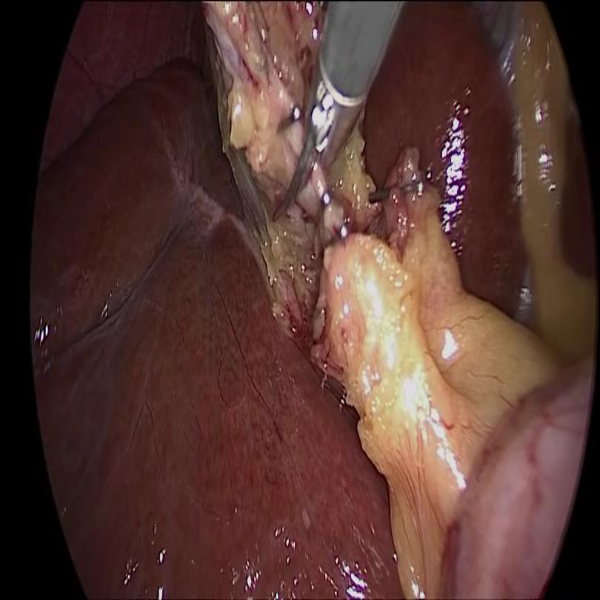

In [11]:
from torchvision.transforms import ToPILImage
t = ToPILImage()
train_features, train_labels = next(iter(train_dataloader))
print(train_features.shape)
t(train_features[0].squeeze(dim=0))

In [12]:
import torch
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

# load pre-trained model
model = fasterrcnn_resnet50_fpn(pretrained=True)

# Get the number of input features of the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features

# Replace the head of a pretrained model to adapt to the number of classes in your dataset
# Assume your dataset has num_classes classes (including background)
num_classes = 8  # Adjust based on the number of categories in your dataset
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:01<00:00, 85.9MB/s]


In [13]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

model.to(device)

# choose optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=0.005, momentum=0.9, weight_decay=0.0005)

# training epoch
num_epochs = 6  # adjust according to needs

for epoch in range(num_epochs):
    model.train()
    for images, targets in train_dataloader:
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

    print(f"Epoch {epoch} Loss: {losses.item()}")



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

Epoch 0 Loss: 0.30322012305259705


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

Epoch 1 Loss: 0.19704300165176392


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

Epoch 2 Loss: 0.1748187094926834


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

Epoch 3 Loss: 0.17014504969120026


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

Epoch 4 Loss: 0.10195944458246231


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

Epoch 5 Loss: 0.16036735475063324


In [ ]:
model_path = "drive/MyDrive/m2cai16-tool-locations/fastRCNN.pth"
model.load_state_dict(torch.load(model_path))

<All keys matched successfully>

In [14]:
import matplotlib.patches as patches
def display_image_with_boxes_true(image, true_labels):
    fig, ax = plt.subplots(1)
    image = image.cpu()
    t = ToPILImage()
    image = t(image)

    # Image with true labels
    ax.imshow(image)
    n_obj_true = len(true_labels['boxes'])
    boxes = true_labels['boxes']
    labels = true_labels['labels']

    for i in range(n_obj_true):
      xmin, ymin, xmax, ymax = boxes[i][0].item(), boxes[i][1].item(), boxes[i][2].item(), boxes[i][3].item()
      rect = patches.Rectangle((xmin, ymin), xmax-xmin, ymax-ymin,
                               linewidth = 1, edgecolor='r', facecolor='none')
      ax.add_patch(rect)
      plt.text(xmin, ymin-5, labels[i], color='r')
    plt.show()


def display_image_with_boxes_pred(image, pred_labels):

    fig, ax = plt.subplots(1)
    image = image.cpu()
    t = ToPILImage()
    image = t(image)

    # Image with predicted labels
    ax.imshow(image)
    n_obj_true = len(pred_labels['boxes'])
    boxes = pred_labels['boxes']
    labels = pred_labels['labels']

    for i in range(n_obj_true):
      xmin, ymin, xmax, ymax = boxes[i][0].item(), boxes[i][1].item(), boxes[i][2].item(), boxes[i][3].item()
      rect = patches.Rectangle((xmin, ymin), xmax-xmin, ymax-ymin,
                               linewidth = 1, edgecolor='r', facecolor='none')
      ax.add_patch(rect)
      plt.text(xmin, ymin-5, labels[i], color='r')
    plt.show()

# display_image_with_boxes(images[0], objects, label_name)

In [15]:
model = model.cuda()
model.eval()
pred = model(train_features.cuda())
pred[1], train_labels[1]

({'boxes': tensor([[309.9434,  96.4429, 488.0057, 284.2310]], device='cuda:0',
         grad_fn=<StackBackward0>),
  'labels': tensor([4], device='cuda:0'),
  'scores': tensor([0.9886], device='cuda:0', grad_fn=<IndexBackward0>)},
 {'boxes': tensor([[320.,  98., 496., 297.]]), 'labels': tensor([4])})

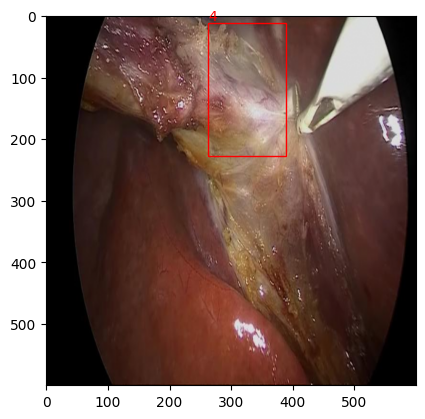

In [19]:
import numpy as np

def draw_boxes(image, boxes, labels):
    fig, ax = plt.subplots(1)
    # image = image.cpu()
    t = ToPILImage()
    image = t(image)

    # Image with true labels
    ax.imshow(image)
    n_obj_true = len(boxes)

    for i in range(n_obj_true):
      xmin, ymin, xmax, ymax = boxes[i][0], boxes[i][1], boxes[i][2], boxes[i][3]
      rect = patches.Rectangle((xmin, ymin), xmax-xmin, ymax-ymin,
                               linewidth = 1, edgecolor='r', facecolor='none')
      ax.add_patch(rect)
      plt.text(xmin, ymin-5, labels[i], color='r')
    plt.show()

def predict(input_tensor, model, device, detection_threshold):
    outputs = model(input_tensor)
    # print(outputs)
    pred_classes = outputs[0]['labels'].cpu().numpy()
    pred_labels = outputs[0]['labels'].cpu().numpy()
    pred_scores = outputs[0]['scores'].detach().cpu().numpy()
    pred_bboxes = outputs[0]['boxes'].detach().cpu().numpy()

    boxes, classes, labels, indices = [], [], [], []
    for index in range(len(pred_scores)):
        if pred_scores[index] >= detection_threshold:
            boxes.append(pred_bboxes[index].astype(np.int32))
            classes.append(pred_classes[index])
            labels.append(pred_labels[index])
            indices.append(index)
    return boxes, classes, labels, indices

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
boxes, classes, labels, indices = predict(train_features[0].unsqueeze(dim=0).cuda(), model, device, 0.9)
# boxes, classes, labels, indices
# image = draw_boxes(boxes, labels, classes, train_features[0].numpy())
# boxes[0][1]
# Show the image:
# Image.fromarray(image)
draw_boxes(train_features[5], boxes, labels)


In [21]:
pip install grad-cam

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 21.6 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for grad-cam: filename=grad_cam-1.4.8-py3-none-any.whl size=38243 sha256=f2190e9f008b1bed58cc11186bfad3bb2d630e000572456721a345f2f30cf0a3
  Stored in directory: /root/.cache/pip/wheels/f8/04/36/94ff3c8a4215826a21946b34c01180817e606989fdf53f7cd6
Successfully built grad-cam


In [22]:
activations = None

def hook(module, input, output):
    global activations
    activations = output.data

# Replace 'your_target_layer' with the actual name or index of the last convolutional layer in your Fast R-CNN model
target_layer = model.backbone.body.layer4[2].relu
hook_handle = target_layer.register_forward_hook(hook)



from pytorch_grad_cam import AblationCAM, EigenCAM
from pytorch_grad_cam.ablation_layer import AblationLayerFasterRCNN
from pytorch_grad_cam.utils.model_targets import FasterRCNNBoxScoreTarget
from pytorch_grad_cam.utils.reshape_transforms import fasterrcnn_reshape_transform
from pytorch_grad_cam.utils.image import show_cam_on_image, scale_accross_batch_and_channels, scale_cam_image

def fasterrcnn_reshape_transform(x):
    target_size = x['pool'].size()[-2 : ]
    activations = []
    for key, value in x.items():
        activations.append(torch.nn.functional.interpolate(torch.abs(value), target_size, mode='bilinear'))
    activations = torch.cat(activations, axis=1)
    return activations


class FasterRCNNBoxScoreTarget:
    """ For every original detected bounding box specified in "bounding boxes",
    	assign a score on how the current bounding boxes match it,
    		1. In IOU
    		2. In the classification score.
    	If there is not a large enough overlap, or the category changed,
    	assign a score of 0.

    	The total score is the sum of all the box scores.
    """

    def __init__(self, labels, bounding_boxes, iou_threshold=0.5):
        self.labels = labels
        self.bounding_boxes = bounding_boxes
        self.iou_threshold = iou_threshold

    def __call__(self, model_outputs):
        output = torch.Tensor([0])
        if torch.cuda.is_available():
            output = output.cuda()

        if len(model_outputs["boxes"]) == 0:
            return output

        for box, label in zip(self.bounding_boxes, self.labels):
            box = torch.Tensor(box[None, :])
            if torch.cuda.is_available():
                box = box.cuda()

            ious = torchvision.ops.box_iou(box, model_outputs["boxes"])
            index = ious.argmax()
            if ious[0, index] > self.iou_threshold and model_outputs["labels"][index] == label:
                score = ious[0, index] + model_outputs["scores"][index]
                output = output + score
        return output

from pytorch_grad_cam.utils.image import show_cam_on_image
target_layers = [model.backbone]
targets = [FasterRCNNBoxScoreTarget(labels=labels, bounding_boxes=boxes)]
cam = EigenCAM(model,
               target_layers,
               use_cuda=torch.cuda.is_available(),
               reshape_transform=fasterrcnn_reshape_transform)



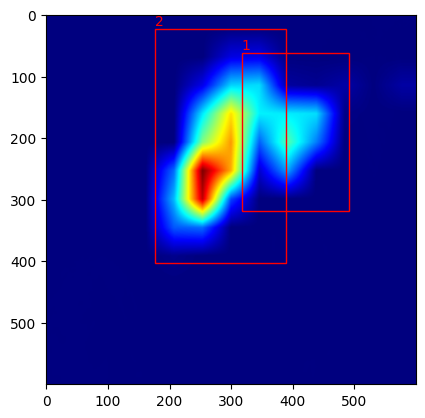

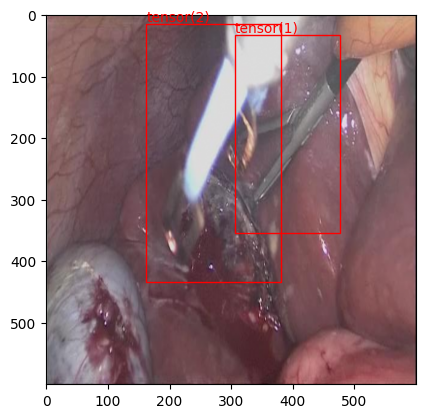

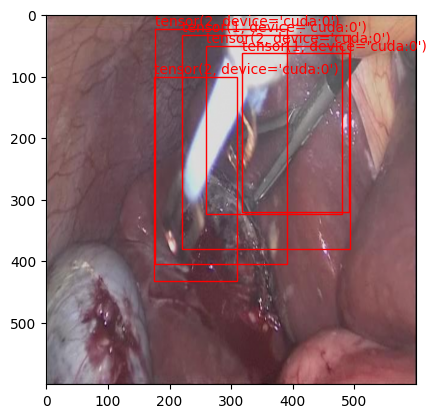

In [23]:
i=6

boxes, classes, labels, indices = predict(train_features[i].unsqueeze(dim=0).cuda(), model, device, 0.9)
image_float_np = train_features[i].numpy() / 255
grayscale_cam = cam(train_features[i].unsqueeze(dim=0), targets=targets)
grayscale_cam = grayscale_cam[0, :]


image_float_np = np.transpose(image_float_np, (1, 2, 0))
cam_image = show_cam_on_image(image_float_np, grayscale_cam, use_rgb = True)

draw_boxes(cam_image, boxes, labels)
display_image_with_boxes_true(train_features[i], train_labels[i])
display_image_with_boxes_pred(train_features[i], pred[i])